In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

DATA_PATH = os.path.join('..', 'data', 'processed', 'dataset_ml_ready.csv')

CHUNK_SIZE = 50000


Librerias cargadas. Datos en: ..\data\processed\dataset_ml_ready.csv


In [2]:
conteo_cwe = {}
conteo_lang = {}
conteo_target = {'Safe': 0, 'Vulnerable': 0}
total_filas = 0

# Acumuladores para metricas numericas (para calcular estadisticas)
metricas_cols = ['nloc', 'complexity', 'token_count', 'top_nesting_level']
suma_metricas = {m: 0 for m in metricas_cols}
suma_cuadrados = {m: 0 for m in metricas_cols}
min_metricas = {m: float('inf') for m in metricas_cols}
max_metricas = {m: float('-inf') for m in metricas_cols}

# Acumuladores para metricas por clase (Safe vs Vulnerable)
metricas_por_clase = {
    'Safe': {m: [] for m in metricas_cols},
    'Vulnerable': {m: [] for m in metricas_cols}
}

print(f"Procesando 100% de los datos por chunks de {CHUNK_SIZE} filas...")

# Procesamos chunk por chunk
for chunk in tqdm(pd.read_csv(DATA_PATH, chunksize=CHUNK_SIZE)):
    total_filas += len(chunk)
    
    # Conteo de CWEs
    for cwe, count in chunk['cwe_id'].value_counts().items():
        conteo_cwe[cwe] = conteo_cwe.get(cwe, 0) + count
    
    # Conteo de lenguajes
    for lang, count in chunk['programming_language'].value_counts().items():
        conteo_lang[lang] = conteo_lang.get(lang, 0) + count
    
    # Conteo Safe vs Vulnerable
    chunk['target_class'] = chunk['cwe_id'].apply(lambda x: 'Safe' if x == 'Safe' else 'Vulnerable')
    for target, count in chunk['target_class'].value_counts().items():
        conteo_target[target] += count
    
    # Estadisticas de metricas numericas
    for m in metricas_cols:
        if m in chunk.columns:
            col_data = chunk[m].dropna()
            suma_metricas[m] += col_data.sum()
            suma_cuadrados[m] += (col_data ** 2).sum()
            min_metricas[m] = min(min_metricas[m], col_data.min())
            max_metricas[m] = max(max_metricas[m], col_data.max())
            
            # Guardamos muestra para boxplots (10% de cada chunk para no explotar RAM)
            safe_data = chunk[chunk['target_class'] == 'Safe'][m].dropna().sample(frac=0.1, random_state=42)
            vuln_data = chunk[chunk['target_class'] == 'Vulnerable'][m].dropna().sample(frac=0.1, random_state=42)
            metricas_por_clase['Safe'][m].extend(safe_data.tolist())
            metricas_por_clase['Vulnerable'][m].extend(vuln_data.tolist())

print(f"\nProcesamiento completo: {total_filas:,} filas analizadas")

Procesando 100% de los datos por chunks de 50000 filas...


4it [02:28, 37.03s/it]


Procesamiento completo: 181,234 filas analizadas


In [3]:
# Calculamos estadisticas descriptivas globales
print("=" * 50)
print("ESTADISTICAS DESCRIPTIVAS (100% de los datos)")
print("=" * 50)

print(f"\nTotal de filas: {total_filas:,}")
print(f"Total de CWEs unicos: {len(conteo_cwe)}")
print(f"Total de lenguajes: {len(conteo_lang)}")

print("\n--- Metricas Numericas ---")
print(f"{'Metrica':<20} | {'Media':<12} | {'Min':<10} | {'Max':<10}")
print("-" * 60)

for m in metricas_cols:
    media = suma_metricas[m] / total_filas
    print(f"{m:<20} | {media:<12.2f} | {min_metricas[m]:<10.2f} | {max_metricas[m]:<10.2f}")

ESTADISTICAS DESCRIPTIVAS (100% de los datos)

Total de filas: 181,234
Total de CWEs unicos: 199
Total de lenguajes: 29

--- Metricas Numericas ---
Metrica              | Media        | Min        | Max       
------------------------------------------------------------
nloc                 | 17.56        | 1.00       | 15154.00  
complexity           | 6.00         | 1.00       | 1399.00   
token_count          | 164.83       | 1.00       | 47711.00  
top_nesting_level    | 0.13         | 0.00       | 66.00     


DISTRIBUCION DE CLASES (100% de los datos)
Safe: 103,946 (57.35%)
Vulnerable: 77,288 (42.65%)


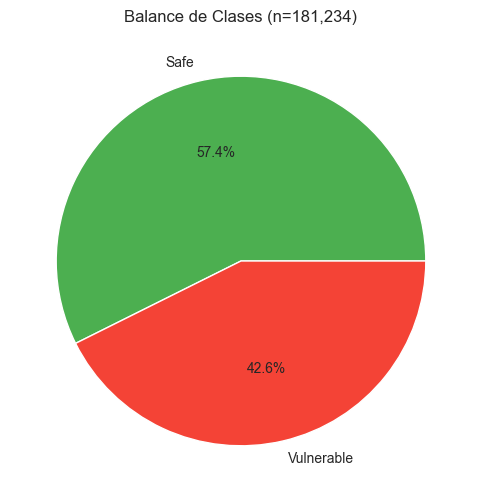

In [4]:
# Distribucion de clases (Safe vs Vulnerable)
print("=" * 50)
print("DISTRIBUCION DE CLASES (100% de los datos)")
print("=" * 50)

for clase, count in conteo_target.items():
    porcentaje = (count / total_filas) * 100
    print(f"{clase}: {count:,} ({porcentaje:.2f}%)")

plt.figure(figsize=(6, 6))
plt.pie(conteo_target.values(), labels=conteo_target.keys(), autopct='%1.1f%%', colors=['#4CAF50', '#F44336'])
plt.title(f'Balance de Clases (n={total_filas:,})')
plt.show()

TOP 10 VULNERABILIDADES (CWE)
CWE_ID          | Cantidad     | Porcentaje
---------------------------------------------
CWE-79          | 16,107       | 20.84%
CWE-89          | 10,276       | 13.30%
CWE-78          | 8,416        | 10.89%
NVD-CWE-noinfo  | 6,374        | 8.25%
CWE-22          | 4,586        | 5.93%
CWE-94          | 3,962        | 5.13%
CWE-93          | 2,250        | 2.91%
CWE-400         | 2,007        | 2.60%
CWE-352         | 1,881        | 2.43%
CWE-434         | 1,734        | 2.24%


C:\Users\edver\AppData\Local\Temp\ipykernel_13728\2920581509.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='CWE', data=top_cwe_df, palette='rocket')


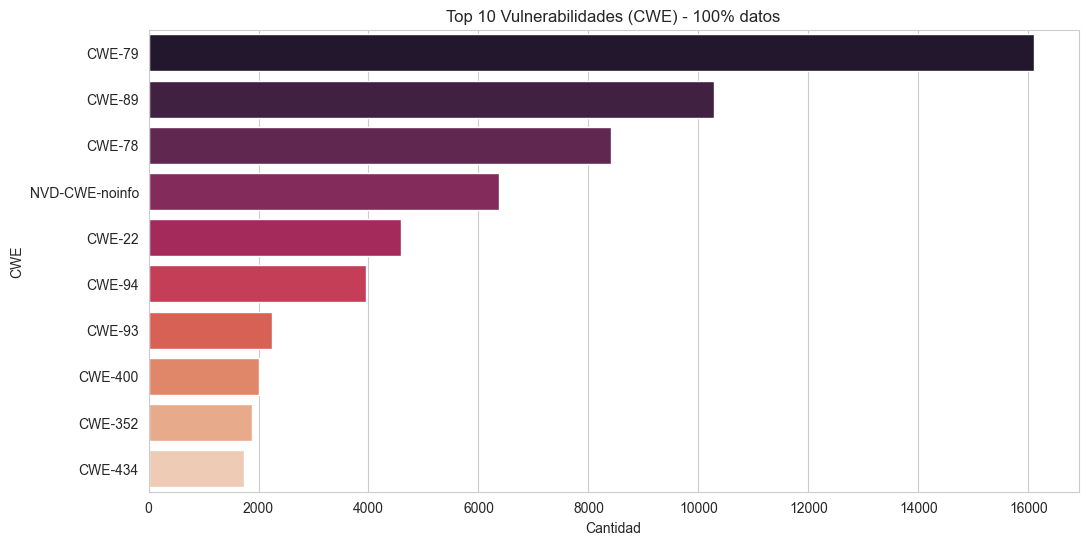

In [5]:
# Top 10 CWEs mas comunes (excluyendo Safe)
print("=" * 50)
print("TOP 10 VULNERABILIDADES (CWE)")
print("=" * 50)

# Filtramos Safe y ordenamos
cwe_vulnerables = {k: v for k, v in conteo_cwe.items() if k != 'Safe'}
top_cwe = sorted(cwe_vulnerables.items(), key=lambda x: x[1], reverse=True)[:10]

print(f"{'CWE_ID':<15} | {'Cantidad':<12} | {'Porcentaje':<10}")
print("-" * 45)
total_vuln = sum(cwe_vulnerables.values())
for cwe, count in top_cwe:
    porc = (count / total_vuln) * 100
    print(f"{cwe:<15} | {count:<12,} | {porc:.2f}%")

# Grafico
top_cwe_df = pd.DataFrame(top_cwe, columns=['CWE', 'Count'])
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='CWE', data=top_cwe_df, palette='rocket')
plt.title('Top 10 Vulnerabilidades (CWE) - 100% datos')
plt.xlabel('Cantidad')
plt.show()

TOP 10 LENGUAJES DE PROGRAMACION
Lenguaje        | Cantidad     | Porcentaje
---------------------------------------------
JavaScript      | 95,731       | 52.82%
PHP             | 19,589       | 10.81%
C               | 13,497       | 7.45%
unknown         | 12,405       | 6.84%
Java            | 7,683        | 4.24%
Python          | 7,018        | 3.87%
Go              | 5,856        | 3.23%
C++             | 4,769        | 2.63%
Markdown        | 4,314        | 2.38%
Ruby            | 3,599        | 1.99%


C:\Users\edver\AppData\Local\Temp\ipykernel_13728\4200344607.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Lenguaje', y='Count', data=top_lang_df, palette='viridis')


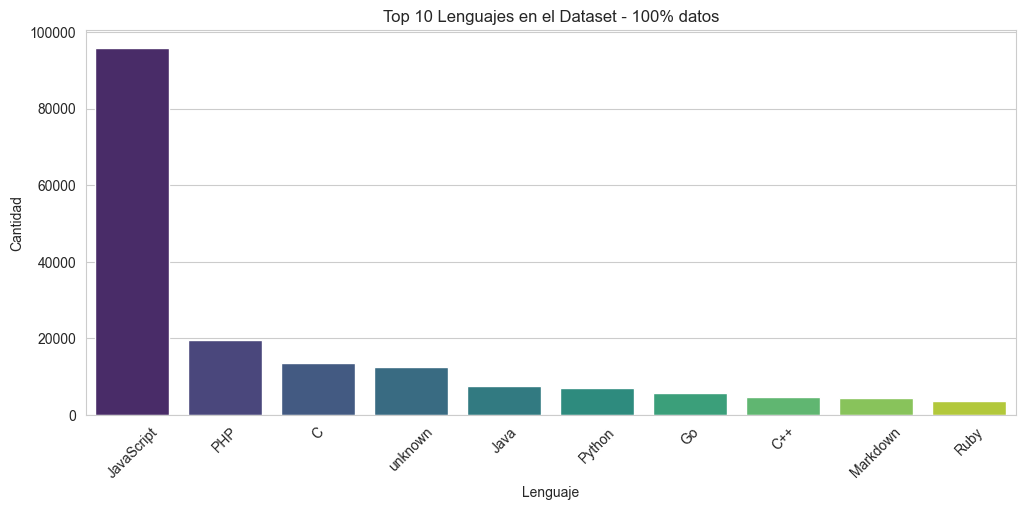

In [6]:
# Top 10 Lenguajes de programacion
print("=" * 50)
print("TOP 10 LENGUAJES DE PROGRAMACION")
print("=" * 50)

top_lang = sorted(conteo_lang.items(), key=lambda x: x[1], reverse=True)[:10]

print(f"{'Lenguaje':<15} | {'Cantidad':<12} | {'Porcentaje':<10}")
print("-" * 45)
for lang, count in top_lang:
    porc = (count / total_filas) * 100
    print(f"{lang:<15} | {count:<12,} | {porc:.2f}%")

# Grafico
top_lang_df = pd.DataFrame(top_lang, columns=['Lenguaje', 'Count'])
plt.figure(figsize=(12, 5))
sns.barplot(x='Lenguaje', y='Count', data=top_lang_df, palette='viridis')
plt.title('Top 10 Lenguajes en el Dataset - 100% datos')
plt.xticks(rotation=45)
plt.ylabel('Cantidad')
plt.show()

Boxplots usando muestra representativa (10% de cada chunk)


C:\Users\edver\AppData\Local\Temp\ipykernel_13728\3199071382.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target_class', y='valor', data=data_m, showfliers=False, palette='Set2')
C:\Users\edver\AppData\Local\Temp\ipykernel_13728\3199071382.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target_class', y='valor', data=data_m, showfliers=False, palette='Set2')
C:\Users\edver\AppData\Local\Temp\ipykernel_13728\3199071382.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target_class', y='valor', data=data_m, showfliers=

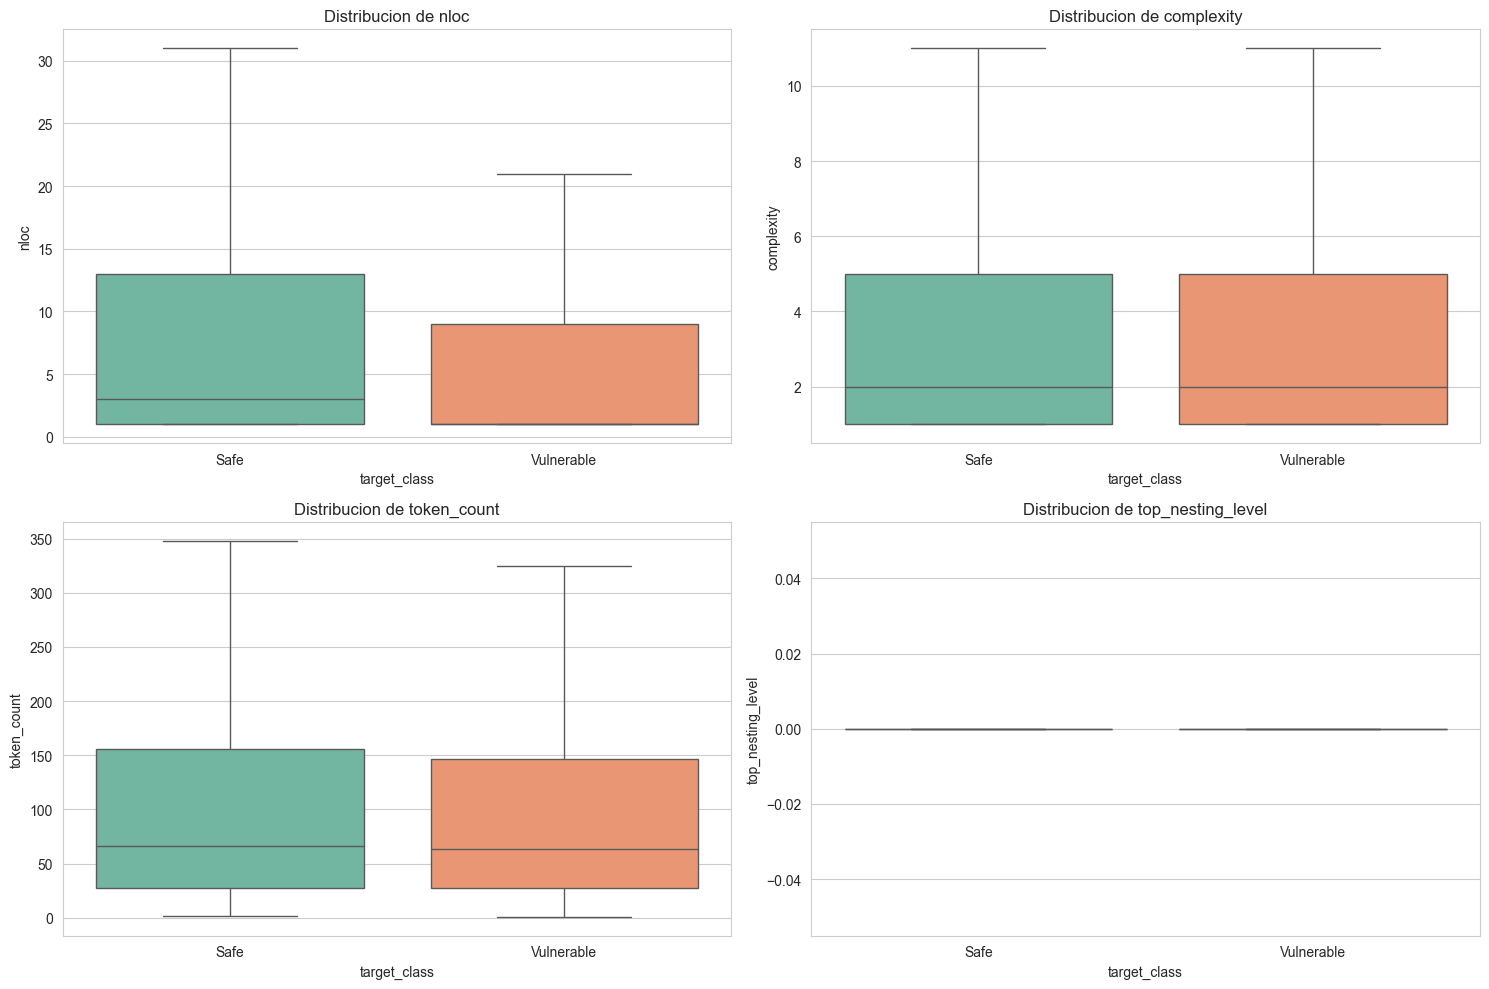

In [7]:
# Boxplots de metricas por clase (usando muestra representativa del 10% para visualizacion)
print("Boxplots usando muestra representativa (10% de cada chunk)")

# Creamos DataFrame para los boxplots
boxplot_data = []
for clase in ['Safe', 'Vulnerable']:
    for m in metricas_cols:
        for val in metricas_por_clase[clase][m]:
            boxplot_data.append({'target_class': clase, 'metrica': m, 'valor': val})

df_boxplot = pd.DataFrame(boxplot_data)

plt.figure(figsize=(15, 10))
for i, m in enumerate(metricas_cols, 1):
    plt.subplot(2, 2, i)
    data_m = df_boxplot[df_boxplot['metrica'] == m]
    sns.boxplot(x='target_class', y='valor', data=data_m, showfliers=False, palette='Set2')
    plt.title(f'Distribucion de {m}')
    plt.ylabel(m)

plt.tight_layout()
plt.show()

Matriz de correlacion (muestra representativa)


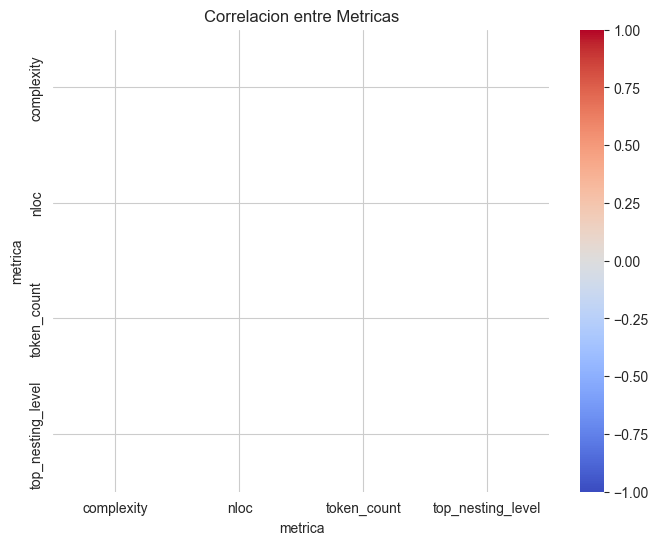


✅ Analisis exploratorio completado con el 100% de los datos!


In [8]:
# Matriz de correlacion (usando la muestra representativa)
print("Matriz de correlacion (muestra representativa)")

# Pivoteamos para tener las metricas como columnas
df_corr = df_boxplot.pivot_table(index=df_boxplot.index, columns='metrica', values='valor').dropna()

plt.figure(figsize=(8, 6))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlacion entre Metricas')
plt.show()

print("\n✅ Analisis exploratorio completado con el 100% de los datos!")